In [1]:
import numpy as np
from numpy.random import binomial, normal, beta, multinomial, multivariate_normal
import scipy.stats as st
from scipy.stats import invgamma, norm, dirichlet
import matplotlib.pyplot as plt
from distcan import InverseGamma
from matplotlib.lines import Line2D
import math
import seaborn as sns
import pandas as pd

def data_gen(mu, sigmas, phi, n):
    """
    Generates samples from Mixture of 2 Gaussian Distributions
    """
    y = []
    for i in range(n):
        ind = multinomial(1, phi)
        for j, val in enumerate(ind):
            if val == 1:
                y.append(norm(mu[j], sigmas[j]).rvs())
            else:
                next
    return np.array(y)

def update_pi(alpha_vec, z_vec):
    """
    Sample from Posterior Conditional for pi
    """
    assert len(z_vec) == len(alpha_vec), "Number of distributions must equal number of parameters"
    return dirichlet(z_vec + alpha_vec).rvs()

def update_mu(y, z_mat, sigma_vec):
    """
    Sample from Posterior Conditional for mu
    """
    mu_vec = []
    n_j =  np.sum(z_mat, axis=0)
    for j in range(len(sigma_vec)):
        sigma_vec[j] = sigma_vec[j] / (n_j[j] + 1)
        mu_vec.append(np.sum(y * z_mat[:,j]) / (n_j[j] + 1))
    
    cov = np.diag(sigma_vec)
    return multivariate_normal(mu_vec, cov)

def update_sigma(data, z_mat, mu):
    """
    Sample from Posterior Conditional for sigma
    """
    n_j = np.sum(z_mat, axis=0)
    alpha = (0.5 * n_j) + 1
    beta = []
    for j in range(len(mu)):
        y = data * z_mat[:,j]
        y = y[y != 0]
        beta.append((0.5 * np.square(y - mu[j]).sum()) + 1)
    return InverseGamma(alpha, beta).rvs()

def update_z(data: list, mu, sigma, pi):
    """
    Sample from latent variable Z according to likelihoods for class assignment
    """
    a = np.empty((len(data), len(mu)))
    out = np.empty((len(data), len(mu)))
    for j in range(len(mu)):
        a[:,j] = norm(mu[j], np.sqrt(sigma[j])).pdf(data) * pi[0,j]
    
    pi_i = a / np.sum(a, axis=1)[:,None]
    for i in range(len(data)):
        out[i,] = multinomial(1, pi_i[i,:])
    return out

def gibbs(data, iters, burnin, k):
    """
    Run Gibb's Sampling for Mixture of 2 Gaussians. Initial States are sample from Priors
    """
    # Set initial guesses based on priors
    alpha = [1,1,1,1]
    mu = normal(0, 1, size=k)
    pi = dirichlet(alpha).rvs()
    sigma = InverseGamma(1,1).rvs(size=k)
    out = np.empty((iters, k*3))

    for i in range(iters):
        # Update Parameters according to conditional posterior distributions
        z_mat = update_z(data, mu, sigma, pi)
        pi = update_pi(alpha, np.sum(z_mat, axis=0))
        mu = update_mu(data, z_mat, sigma)
        sigma = update_sigma(data, z_mat, mu)

        # Store Values to monitor trace
        out[i, 0:4] = mu
        out[i, 4:8] = np.sqrt(sigma)
        out[i, 8:12] = pi[0,:]
    
    return out[burnin:,:]


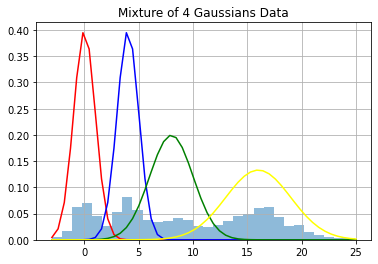

In [2]:
# Set Starting Parameters
mu = [0,4,8,16]
sigmas = [1,1,2,3]
phi = [.2,.2,.2,.4]
n = 2000
y = data_gen(mu=mu, sigmas=sigmas, phi=phi, n=n)
x = np.linspace(-3,25)

# Create Plot of Data 
plt.hist(y, 30, density=True, alpha=0.5)
plt.plot(x, norm(mu[0], sigmas[0]).pdf(x), color="red")
plt.plot(x, norm(mu[1], sigmas[1]).pdf(x), color="blue")
plt.plot(x, norm(mu[2], sigmas[2]).pdf(x), color="green")
plt.plot(x, norm(mu[3], sigmas[3]).pdf(x), color="yellow")
plt.title("Mixture of 4 Gaussians Data")
plt.grid()
plt.show()

In [3]:
# Fit the model and extract parameters
trace = gibbs(y, 2000, 500, 4)
params_dict = {}
for j in range(len(mu)):
    params_dict.update(
        {
            f"mu{j}": np.round(np.mean(trace[:,j]),2),
            f"sigma{j}": np.round(np.mean(trace[:,j+4]),2),
            f"pi{j}": np.round(np.mean(trace[:,j+8]),2)
        }
    )

{'mu0': 0.01, 'sigma0': 1.02, 'pi0': 0.19, 'mu1': 16.06, 'sigma1': 2.99, 'pi1': 0.42, 'mu2': 3.65, 'sigma2': 1.0, 'pi2': 0.15, 'mu3': 7.39, 'sigma3': 2.42, 'pi3': 0.25}


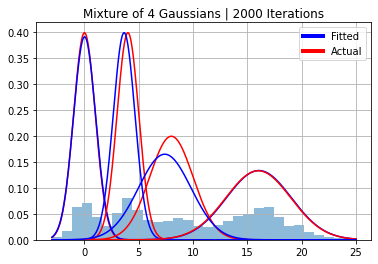

In [4]:
x = np.linspace(-3,25, 500)
plt.hist(y, 30, density=True, alpha=0.5)
for j in range(len(mu)):
    plt.plot(x, norm(mu[j], sigmas[j]).pdf(x), color="red")
    plt.plot(x, norm(params_dict[f"mu{j}"], params_dict[f"sigma{j}"]).pdf(x), color="blue")
plt.title(f"Mixture of 4 Gaussians | {n} Iterations")
legend_elements = [
    Line2D([0], [0], color='blue', lw=4, label='Fitted'),
    Line2D([0], [0], color='red', lw=4, label='Actual')
] 
plt.legend(handles=legend_elements, loc="upper right")
plt.grid()
plt.show()

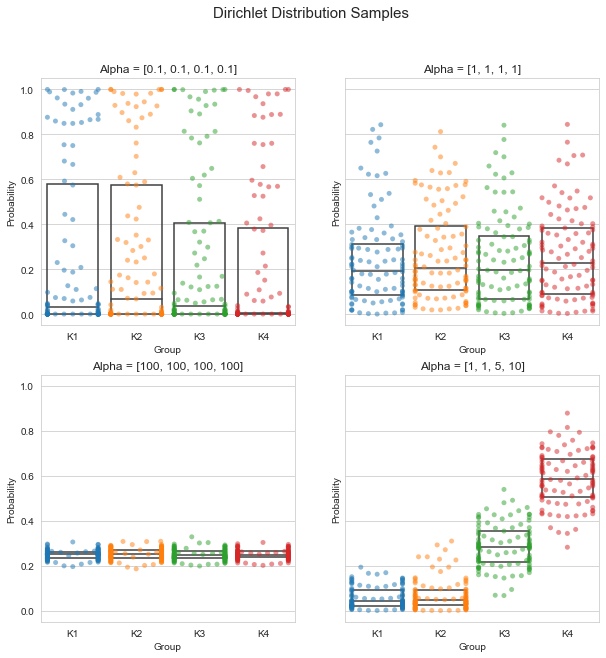

In [34]:
# Plot Dirichlet Distribution
num_samples = 100
num_classes = 4
alpha = [
    [.1,.1,.1,.1],
    [1,1,1,1],
    [100,100,100,100],
    [1,1,5,10]
]

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, sharey=True)

for j, params in enumerate(alpha):
    out = np.empty([num_samples, num_classes])
    for i in range(num_samples):
        out[i,:] = dirichlet(params).rvs()

    sns.set_style("whitegrid")
    out = pd.DataFrame(out,columns=["K1", "K2", "K3", "K4"]).melt(var_name="Group", value_name="Probability")
    sns.swarmplot(x="Group", y="Probability", data=out, ax=eval(f"ax{j+1}"), alpha=0.5)
    sns.boxplot(x="Group", y="Probability", data=out,ax=eval(f"ax{j+1}"),
            showcaps=False,boxprops={'facecolor':'None'},
            showfliers=False,whiskerprops={'linewidth':0})
    eval(f"ax{j+1}").set_title(f"Alpha = {params}")

fig.suptitle("Dirichlet Distribution Samples", fontsize=15)
fig.set_figheight(10)
fig.set_figwidth(10)
#fig.subplots_adjust(hspace=1)


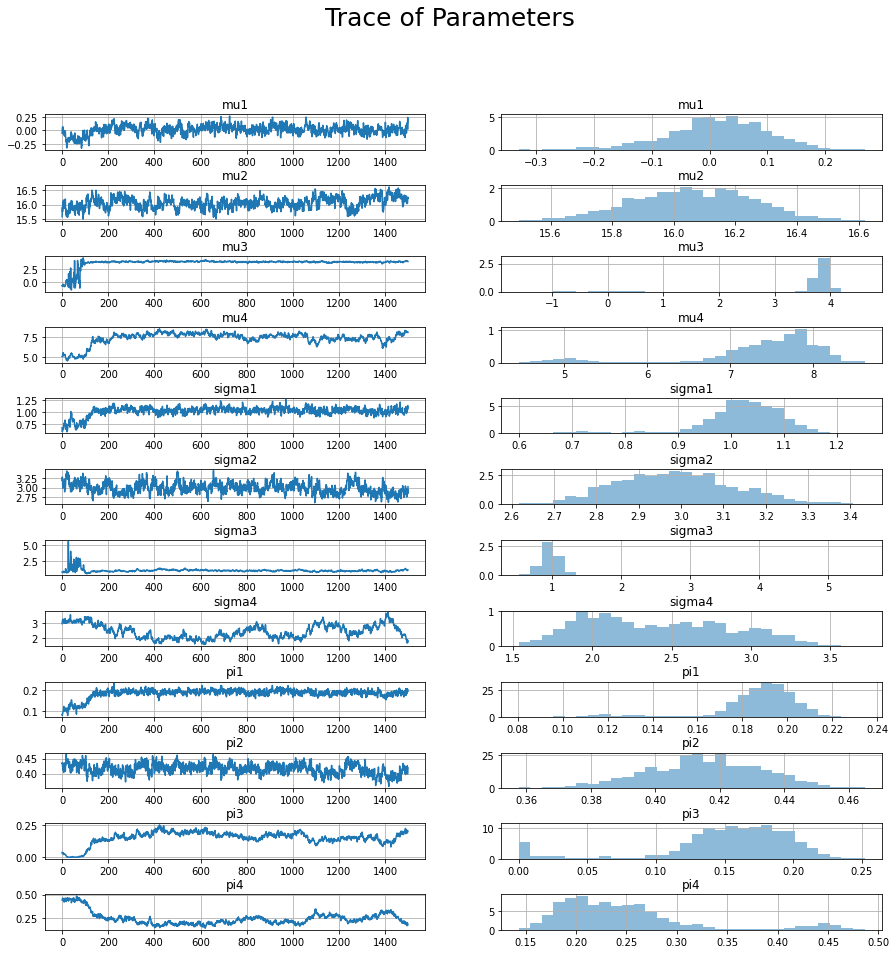

In [27]:
fig, axs = plt.subplots(12,2)
x = range(trace.shape[0])
params = ["mu1", "mu2", "mu3", "mu4", "sigma1", "sigma2", "sigma3", "sigma4", "pi1", "pi2", "pi3", "pi4"]
for i, v in enumerate(params):
    y = trace[:,i]
    axs[i,0].plot(x, y)
    axs[i,0].set_title(v)
    axs[i,1].hist(y, 30, density=True, alpha=0.5)
    axs[i,1].set_title(v)
    axs[i,0].grid()
    axs[i,1].grid()

fig.suptitle("Trace of Parameters", fontsize=25)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=1)
fig.show()